# Settings

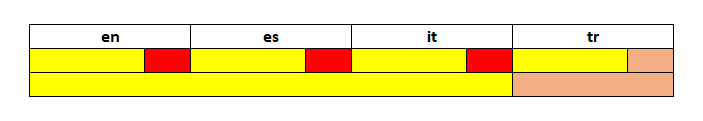

In [1]:
# CONTROLS
MODEL_PREFIX = "V07"
MODEL_NUMBER = MODEL_PREFIX[-2:]
MODEL_NAME = 'distilbert' # options include 'xlm' or 'distilbert'

NUM_EPOCHS = [2, 2, 1]
LR = 5e-5
MAX_SEQ_LEN = 75
SAMPLE_SIZE = 3000
PSUEDO_PROB_THRESH_LOW = 0.05
PSUEDO_PROB_THRESH_HIGH = 0.65

RUN_ON_SAMPLE = 0
ON_KAGGLE = False

if ON_KAGGLE:
    BATCH_SIZE = 64
    PREDICT_BATCH_SIZE = 1024
else:
    BATCH_SIZE = 16
    PREDICT_BATCH_SIZE = 256

TRAIN_SPLIT_RATIO = 0.2
DROPOUT = 0.3
LABEL_SMOOTHING_PARAM = 0.1

In [2]:
if ON_KAGGLE:
    RESULTS_DIR = '../working/'
    DATA_DIR = '../input/jigsaw-multilingual-toxic-comment-classification/'
    if MODEL_NAME == 'xlm':
        MODEL_DIR = '../input/tf-xlm-roberta-base/'
    else:
        MODEL_DIR = '../input/tf-distilbert-base-multilingual-cased/'
else:
    PATH = ".." #"/content/drive/My Drive/Kaggle/jigsaw-multilingual-toxic-comment-classification"
    RESULTS_DIR = PATH+"/results/"
    DATA_DIR = PATH+"/data/"
    if MODEL_NAME == 'xlm':
        MODEL_DIR = PATH+"/models/tf-xlm-roberta-base/"
    else:
        MODEL_DIR = PATH+"/models/distilbert-base-multilingual-cased/"

# Libraries

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, LeaveOneGroupOut
from sklearn.utils import class_weight

import pickle, os, sys, re, json, gc
from time import time, ctime
from pprint import pprint
from collections import Counter

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply, Layer, LeakyReLU, Subtract
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.callbacks import *
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import to_categorical

import tokenizers, transformers
from transformers import *

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import TriangularCyclicalLearningRate

%matplotlib inline

In [4]:
seeded_value = 654123
pd.set_option('display.max_colwidth', None)
np.random.seed(seeded_value)
tf.random.set_seed(seeded_value)

In [5]:
print(ctime(time()))

Fri Jun 19 16:06:29 2020


In [6]:
print([
    tf.__version__,
    transformers.__version__,
    tokenizers.__version__
])

['2.1.0', '2.8.0', '0.5.2']


<a href="https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth"  target="_blank"><h2 id="limiting_gpu_memory_growth" data-text="Limiting GPU memory growth" tabindex="0">Limiting GPU memory growth</h2></a>
<p>By default, TensorFlow maps nearly all of the GPU memory of all GPUs (subject to
<a href="https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars"><code translate="no" dir="ltr">CUDA_VISIBLE_DEVICES</code></a>) visible to the process. This is done to more efficiently use the relatively precious GPU memory resources on the devices by reducing memory fragmentation. To limit TensorFlow to a specific set of GPUs we use the <code translate="no" dir="ltr">tf.config.experimental.set_visible_devices</code> method.</p>

In [7]:
print(tf.config.experimental.list_logical_devices('CPU'))
print(tf.config.experimental.list_logical_devices('GPU'))
print(tf.config.experimental.list_physical_devices('CPU'))
print(tf.config.experimental.list_physical_devices('GPU'))

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Import Data

In [9]:
train = pd.read_csv(DATA_DIR+'jigsaw-toxic-comment-train.csv')
validation = pd.read_csv(DATA_DIR+'validation.csv')
test = pd.read_csv(DATA_DIR+'test.csv')

In [10]:
train['lang'] = 'en'

train['set'] = 'train'
validation['set'] = 'valid'
test['set'] = 'test'

test['toxic'] = 0

In [11]:
print(train.columns)
print(validation.columns)
print(test.columns)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'lang', 'set'],
      dtype='object')
Index(['id', 'comment_text', 'lang', 'toxic', 'set'], dtype='object')
Index(['id', 'content', 'lang', 'set', 'toxic'], dtype='object')


In [12]:
validation.lang.unique(), test.lang.unique()

(array(['es', 'it', 'tr'], dtype=object),
 array(['tr', 'ru', 'it', 'fr', 'pt', 'es'], dtype=object))

In [13]:
train.columns = ['id', 'text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'lang', 'set']
validation.columns = ['id', 'text', 'lang', 'toxic', 'set']
test.columns = ['id', 'text', 'lang', 'set', 'toxic']

In [14]:
REQ_COLS = ['id', 'set', 'text', 'lang', 'toxic']

In [15]:
train['text'] = train["text"].astype(str)
validation['text'] = validation["text"].astype(str)
test['text'] = test["text"].astype(str)

In [16]:
data = pd.concat([train[REQ_COLS].sample(SAMPLE_SIZE, random_state=seeded_value),
                  validation[REQ_COLS]], axis=0)

In [17]:
data.shape

(11000, 5)

In [18]:
data.sample(2)

,id,set,text,lang,toxic
205996,b8e77c1e7bc44922,train,:::Please read my comments at the top of this page. Bye.,en,0
5397,5397,valid,Sağol ama bu değil. Geçmişte maddenin benim tarafından açılıp ilk önce 50 civarında katkı yaptığım gözükmesi gerekirdi:-/ Neyse boşver. selamlar Erdall,tr,0


In [19]:
data.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id     toxic
set   lang                
train en    3000  0.098000
valid es    2500  0.168800
      it    2500  0.195200
      tr    3000  0.106667

In [20]:
test.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id  toxic
set  lang              
test es     8438      0
     fr    10920      0
     it     8494      0
     pt    11012      0
     ru    10948      0
     tr    14000      0

In [21]:
if RUN_ON_SAMPLE>0:
    data = data.sample(RUN_ON_SAMPLE).copy().reset_index(drop=True)
    test = test.sample(RUN_ON_SAMPLE).copy().reset_index(drop=True)

# Tokenizer, Config & Model Initialization

1. https://arxiv.org/pdf/1911.02116.pdf
2. https://huggingface.co/transformers/model_doc/xlmroberta.html

In [22]:
if MODEL_NAME == 'xlm':
    xlmr_tok = transformers.XLMRobertaTokenizer.from_pretrained(MODEL_DIR)
else:
    xlmr_tok = transformers.DistilBertTokenizer.from_pretrained(MODEL_DIR)

In [23]:
with open(MODEL_DIR+"special_tokens_map.json") as f:
    special_tokens = json.load(f)
xlmr_tok.add_special_tokens(special_tokens)

0

In [24]:
VOCAB_SIZE = xlmr_tok.vocab_size
print(VOCAB_SIZE)

119547


# Tokenization

In [25]:
X_tokens, X_att = [], []
for t in data.text.tolist():
    encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
    X_tokens.append(encoded_text['input_ids'])
    X_att.append(encoded_text['attention_mask'])

X_tokens, X_att, X_lang, Y_toxic = np.array(X_tokens), np.array(X_att), data['lang'].values, data['toxic'].values

In [26]:
X_tokens_test, X_att_test = [], []
for t in test.text.tolist():
    encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
    X_tokens_test.append(encoded_text['input_ids'])
    X_att_test.append(encoded_text['attention_mask'])

X_tokens_test, X_att_test = np.array(X_tokens_test), np.array(X_att_test)

print("\n",
      X_tokens_test.shape, "\t: X_tokens_test ", "\n",
      X_att_test.shape, "\t: X_att_test ", "\n"
)


 (63812, 75) 	: X_tokens_test  
 (63812, 75) 	: X_att_test  



In [27]:
if os.path.exists(DATA_DIR+"ProcessedData.pickle"):
    with open(DATA_DIR+"ProcessedData.pickle", "rb") as f:
        pickle.dump((X_tokens, X_att, X_lang, Y_toxic, X_tokens_test, X_att_test), f)

In [28]:
if os.path.exists(DATA_DIR+"ProcessedData.pickle"):
    with open(DATA_DIR+"ProcessedData.pickle", "rb") as f:
        X_tokens, X_att, X_lang, Y_toxic, X_tokens_test, X_att_test = pickle.load(f)

# Model Specifications

In [29]:
def build_model():
    input_sequences = Input((MAX_SEQ_LEN), dtype=tf.int32, name="words")
    input_att_flags = Input((MAX_SEQ_LEN), dtype=tf.int32, name="att_flags")
    
    if MODEL_NAME == 'xlm':
        config = transformers.XLMRobertaConfig.from_pretrained(MODEL_DIR)
        model = transformers.TFXLMRobertaModel.from_pretrained(MODEL_DIR, config=config) # TFXLMRobertaForSequenceClassification
        x = model(inputs=input_sequences, attention_mask=input_att_flags)
    else:
        config = transformers.DistilBertConfig.from_pretrained(MODEL_DIR)
        model = transformers.TFDistilBertModel.from_pretrained(MODEL_DIR) # TFDistilBertForSequenceClassification
        x = model(inputs=input_sequences, attention_mask=input_att_flags)
    
    x1 = tf.keras.layers.Dropout(DROPOUT)(x[0])
    x1 = tf.keras.layers.Conv1D(768, 2, padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    toxic_output = tf.keras.layers.Activation('sigmoid', name="toxic_output")(x1)
    
    model = Model([input_att_flags, input_sequences],
                  [toxic_output])
    
    return model

In [30]:
model = build_model()

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 75)]         0                                            
__________________________________________________________________________________________________
att_flags (InputLayer)          [(None, 75)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 75, 768),)   134734080   words[0][0]                      
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 75, 768)      0           tf_distil_bert_model[0][0]       
______________________________________________________________________________________________

# Cross Validation Strategy

KFold Stratified train-validation split

In [32]:
#NUM_FOLDS = 3
#skf = StratifiedKFold(NUM_FOLDS, shuffle=True, random_state=seeded_value)

Leave one language out split

In [33]:
#logo = LeaveOneGroupOut()
#for t_index, v_index in logo.split(np.arange(X_tokens.shape[0]), np.arange(X_tokens.shape[0]), groups=X_lang):
#    print(X_lang[t_index])
#    #print(np.unique(X_lang[v_index]))

Simple random train-validation split

In [34]:
t_index, v_index = train_test_split(np.arange(X_tokens.shape[0]), shuffle=True, random_state=seeded_value)

# Model Fit

<a href="https://keras.io/guides/transfer_learning/#finetuning" target="_blank"><h2 id="finetuning">Fine-tuning</h2></a>
<p>Once your model has converged on the new data, you can try to unfreeze all or part of
 the base model and retrain the whole model end-to-end with a very low learning rate.</p>
 <p>This is an optional last step that can potentially give you incremental improvements.
 It could also potentially lead to quick overfitting -- keep that in mind.</p>
 <p>It is critical to only do this step <em>after</em> the model with frozen layers has been
trained to convergence. If you mix randomly-initialized trainable layers with
trainable layers that hold pre-trained features, the randomly-initialized layers will
cause very large gradient updates during training, which will destroy your pre-trained
 features.</p>
 <p>It's also critical to use a very low learning rate at this stage, because
you are training a much larger model than in the first round of training, on a dataset
 that is typically very small.
As a result, you are at risk of overfitting very quickly if you apply large weight
 updates. Here, you only want to readapt the pretrained weights in an incremental way.</p>

<a href="https://keras.io/guides/transfer_learning/#finetuning" target="_blank"><p><strong>Important note about <code>compile()</code> and <code>trainable</code></strong></p></a>
<p>Calling <code>compile()</code> on a model is meant to "freeze" the behavior of that model. This
 implies that the <code>trainable</code>
attribute values at the time the model is compiled should be preserved throughout the
 lifetime of that model,
until <code>compile</code> is called again. Hence, if you change any <code>trainable</code> value, make sure
 to call <code>compile()</code> again on your
model for your changes to be taken into account.</p>

In [35]:
pred = np.zeros((len(X_tokens), 1))
pred_test = np.zeros((len(X_tokens_test), 1))
timings_dict = {}

In [36]:
num=0
valid_lang='all'
start_time = time()

if num>0:
    del model
    del mcp
    del csvl
    del adam
    del history
    del auc
    gc.collect()
    K.clear_session()

model = build_model()
auc = tf.keras.metrics.AUC()
mcp = ModelCheckpoint(filepath=RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+valid_lang+"_"+str(num)+".h5", monitor='val_auc',
                      verbose=0, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')
csvl = CSVLogger(filename=RESULTS_DIR+MODEL_PREFIX+"_LossLogs_"+valid_lang+"_"+str(num)+".csv",
                 separator=",", append=True)

model.layers[3].trainable = False
adam = Adam(learning_rate=LR)
model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
              optimizer=adam,
              metrics=['accuracy', auc])

train_time = time()
history = model.fit(x={"att_flags":X_att[t_index],
                       "words":X_tokens[t_index]},
                    y={"toxic_output":Y_toxic[t_index]},
                    validation_data=({"att_flags":X_att[v_index],
                                      "words":X_tokens[v_index]},
                                     {"toxic_output":Y_toxic[v_index]}),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[0],
                    shuffle=True,
                    verbose=1,
                    callbacks=[mcp, csvl])

Train on 8250 samples, validate on 2750 samples
Epoch 1/2
8250/8250 [==============================] - 123s 15ms/sample - loss: 0.4276 - accuracy: 0.8588 - auc: 0.7772 - val_loss: 0.4307 - val_accuracy: 0.8629 - val_auc: 0.8193
Epoch 2/2
8250/8250 [==============================] - 110s 13ms/sample - loss: 0.3357 - accuracy: 0.9105 - auc: 0.9333 - val_loss: 0.3749 - val_accuracy: 0.8905 - val_auc: 0.9113


In [37]:
pred_initial = model.predict(x = {"att_flags":X_att,
                                  "words":X_tokens},
                             batch_size=PREDICT_BATCH_SIZE)

print("Train ROC-AUC:\t", roc_auc_score(y_true=Y_toxic[t_index], y_score=pred_initial[t_index]))
print("Valid ROC-AUC:\t", roc_auc_score(y_true=Y_toxic[v_index], y_score=pred_initial[v_index]))

print("Train Accuracy:\t", accuracy_score(y_true=Y_toxic[t_index], y_pred=np.where(pred_initial[t_index]>0.5, 1, 0)))
print("Valid Accuracy:\t", accuracy_score(y_true=Y_toxic[v_index], y_pred=np.where(pred_initial[v_index]>0.5, 1, 0)))

print(classification_report(y_true=Y_toxic[t_index], y_pred=np.where(pred_initial[t_index]>0.5, 1, 0)))
print(classification_report(y_true=Y_toxic[v_index], y_pred=np.where(pred_initial[v_index]>0.5, 1, 0)))

Train ROC-AUC:	 0.9892527722785376
Valid ROC-AUC:	 0.9112622350819755
Train Accuracy:	 0.9585454545454546
Valid Accuracy:	 0.8905454545454545
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      7113
           1       0.81      0.92      0.86      1137

    accuracy                           0.96      8250
   macro avg       0.90      0.94      0.92      8250
weighted avg       0.96      0.96      0.96      8250

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2363
           1       0.60      0.68      0.64       387

    accuracy                           0.89      2750
   macro avg       0.77      0.80      0.79      2750
weighted avg       0.90      0.89      0.89      2750



In [38]:
# Psuedo model fit
psuedo_time = time()

# Accumulate test results after training every fold
pred_psuedo = model.predict(x = {"att_flags":X_att_test,
                                 "words":X_tokens_test},
                            batch_size=PREDICT_BATCH_SIZE).reshape((-1))

In [39]:
test['toxic'] = pred_psuedo

In [40]:
test['toxic'].describe()

count    63812.000000
mean         0.282639
std          0.245812
min          0.011453
25%          0.105366
50%          0.179497
75%          0.377658
max          0.943357
Name: toxic, dtype: float64

In [41]:
test.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id     toxic
set  lang                 
test es     8438  0.328209
     fr    10920  0.313224
     it     8494  0.339528
     pt    11012  0.268778
     ru    10948  0.255230
     tr    14000  0.229127

In [42]:
test.groupby(["set", "lang"]).apply(pd.Series.describe)

id         toxic
set  lang                                  
test es   count   8438.000000   8438.000000
          mean   32405.344039      0.328209
          std    18373.331400      0.291553
          min        7.000000      0.016353
          25%    16665.000000      0.097131
          50%    32646.500000      0.184129
          75%    48250.250000      0.589129
          max    63811.000000      0.943357
     fr   count  10920.000000  10920.000000
          mean   31676.724176      0.313224
          std    18378.065199      0.242692
          min        5.000000      0.024004
          25%    15838.500000      0.133062
          50%    31451.500000      0.212880
          75%    47618.750000      0.435619
          max    63800.000000      0.941028
     it   count   8494.000000   8494.000000
          mean   31916.568048      0.339528
          std    18416.472108      0.269539
          min        2.000000      0.018956
          25%    16118.000000      0.122305
          50%    31959.500000      0.229749
          75%    47677.250000      0.542318
          max    63809.000000      0.940357
     pt   count  11012.000000  11012.000000
          mean   31795.557937      0.268777
          std    18540.963518      0.231364
          min        6.000000      0.023072
          25%    15683.750000      0.107991
          50%    31609.000000      0.169088
          75%    47991.500000      0.339189
          max    63798.000000      0.937752
     ru   count  10948.000000  10948.000000
          mean   31952.666423      0.255230
          std    18307.410026      0.167966
          min        1.000000      0.024970
          25%    16051.750000      0.139642
          50%    32195.000000      0.203541
          75%    47751.750000      0.313072
          max    63803.000000      0.936164
     tr   count  14000.000000  14000.000000
          mean   31825.560000      0.229128
          std    18477.674436      0.249932
          min        0.000000      0.011453
          25%    15613.750000      0.072583
          50%    31902.500000      0.114556
          75%    47873.500000      0.247613
          max    63810.000000      0.940093

In [43]:
Y_toxic_psuedo = np.where(pred_psuedo >= PSUEDO_PROB_THRESH_HIGH, 1, 0)
psuedo_flag = (pred_psuedo >= PSUEDO_PROB_THRESH_HIGH) | (pred_psuedo <= PSUEDO_PROB_THRESH_LOW)

print("Number of psuedo samples available:", sum(psuedo_flag))
print("Psuedo Toxicity:", sum(Y_toxic_psuedo))
print(Counter(test.lang.values))
print(Counter(test.lang.values[psuedo_flag]))

X_att_psuedo = np.concatenate((X_att[t_index], X_att_test[psuedo_flag]))
X_tokens_psuedo = np.concatenate((X_tokens[t_index], X_tokens_test[psuedo_flag]))
Y_toxic_psuedo = np.concatenate((Y_toxic[t_index], Y_toxic_psuedo[psuedo_flag]))

shuffled_idxs = np.arange(Y_toxic_psuedo.shape[0])
np.random.shuffle(shuffled_idxs)

auc = tf.keras.metrics.AUC()
mcp = ModelCheckpoint(filepath=RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+valid_lang+"_"+str(num)+".h5", monitor='val_auc',
                      verbose=0, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')
csvl = CSVLogger(filename=RESULTS_DIR+MODEL_PREFIX+"_LossLogs_"+valid_lang+"_"+str(num)+".csv",
                 separator=",", append=True)

model.layers[3].trainable = False
adam = Adam(learning_rate=LR)
model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
              optimizer=adam,
              metrics=['accuracy', auc])

history = model.fit(x={"att_flags":X_att_psuedo[shuffled_idxs],
                       "words":X_tokens_psuedo[shuffled_idxs]},
                    y={"toxic_output":Y_toxic_psuedo[shuffled_idxs]},
                    validation_data=({"att_flags":X_att[v_index],
                                      "words":X_tokens[v_index]},
                                     {"toxic_output":Y_toxic[v_index]}),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[1],
                    shuffle=True,
                    verbose=1,
                    callbacks=[mcp, csvl])

model.layers[3].trainable = True
adam = Adam(learning_rate=LR*0.1)
model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
              optimizer=adam,
              metrics=['accuracy', auc])

history = model.fit(x={"att_flags":X_att_psuedo[shuffled_idxs],
                       "words":X_tokens_psuedo[shuffled_idxs]},
                    y={"toxic_output":Y_toxic_psuedo[shuffled_idxs]},
                    validation_data=({"att_flags":X_att[v_index],
                                      "words":X_tokens[v_index]},
                                     {"toxic_output":Y_toxic[v_index]}),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[2],
                    shuffle=True,
                    verbose=1,
                    callbacks=[mcp, csvl])

Number of psuedo samples available: 11324
Psuedo Toxicity: 8805
Counter({'tr': 14000, 'pt': 11012, 'ru': 10948, 'fr': 10920, 'it': 8494, 'es': 8438})
Counter({'tr': 3020, 'es': 2425, 'it': 1871, 'fr': 1794, 'pt': 1551, 'ru': 663})
Train on 19574 samples, validate on 2750 samples
Epoch 1/2
19574/19574 [==============================] - 255s 13ms/sample - loss: 0.2805 - accuracy: 0.9558 - auc_1: 0.9864 - val_loss: 0.4161 - val_accuracy: 0.8680 - val_auc_1: 0.8921
Epoch 2/2
19574/19574 [==============================] - 244s 12ms/sample - loss: 0.2418 - accuracy: 0.9764 - auc_1: 0.9952 - val_loss: 0.4208 - val_accuracy: 0.8844 - val_auc_1: 0.8663
Train on 19574 samples, validate on 2750 samples
19574/19574 [==============================] - 255s 13ms/sample - loss: 0.2115 - accuracy: 0.9937 - auc_1: 0.9995 - val_loss: 0.4459 - val_accuracy: 0.8771 - val_auc_1: 0.8660


In [44]:
infer_time = time()

# Loading best weights per fold
model.load_weights(RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+valid_lang+"_"+str(num)+".h5")

pred += model.predict(x = {"att_flags":X_att,
                                "words":X_tokens},
                           batch_size=PREDICT_BATCH_SIZE)

print("Train ROC-AUC:\t", roc_auc_score(y_true=Y_toxic[t_index], y_score=pred[t_index]))
print("Valid ROC-AUC:\t", roc_auc_score(y_true=Y_toxic[v_index], y_score=pred[v_index]))

print("Train Accuracy:\t", accuracy_score(y_true=Y_toxic[t_index], y_pred=np.where(pred[t_index]>0.5, 1, 0)))
print("Valid Accuracy:\t", accuracy_score(y_true=Y_toxic[v_index], y_pred=np.where(pred[v_index]>0.5, 1, 0)))

print(classification_report(y_true=Y_toxic[t_index], y_pred=np.where(pred[t_index]>0.5, 1, 0)))
print(classification_report(y_true=Y_toxic[v_index], y_pred=np.where(pred[v_index]>0.5, 1, 0)))

# Accumulate test results after training every fold

pred_test += model.predict(x = {"att_flags":X_att_test,
                                "words":X_tokens_test},
                           batch_size=PREDICT_BATCH_SIZE)

end_time = time()
timings_dict.update({num:{
    'start_time' : ctime(start_time),
    'train_time' : ctime(train_time),
    'infer_time' : ctime(infer_time),
    'psuedo_time' : ctime(psuedo_time),
    'end_time' : ctime(end_time),
}})

Train ROC-AUC:	 0.9892527722785376
Valid ROC-AUC:	 0.9112622350819755
Train Accuracy:	 0.9585454545454546
Valid Accuracy:	 0.8905454545454545
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      7113
           1       0.81      0.92      0.86      1137

    accuracy                           0.96      8250
   macro avg       0.90      0.94      0.92      8250
weighted avg       0.96      0.96      0.96      8250

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2363
           1       0.60      0.68      0.64       387

    accuracy                           0.89      2750
   macro avg       0.77      0.80      0.79      2750
weighted avg       0.90      0.89      0.89      2750



In [45]:
pd.DataFrame.from_dict(timings_dict)

,0
end_time,Fri Jun 19 16:31:17 2020
infer_time,Fri Jun 19 16:28:17 2020
psuedo_time,Fri Jun 19 16:13:12 2020
start_time,Fri Jun 19 16:08:49 2020
train_time,Fri Jun 19 16:08:52 2020


In [46]:
test['toxic'] = pred_test

In [47]:
test[['id','toxic']].to_csv(RESULTS_DIR+"submission.csv", index=False)

In [48]:
test['toxic'].describe()

count    63812.000000
mean         0.282636
std          0.245812
min          0.011453
25%          0.105366
50%          0.179497
75%          0.377658
max          0.943357
Name: toxic, dtype: float64

In [49]:
test.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id     toxic
set  lang                 
test es     8438  0.328209
     fr    10920  0.313224
     it     8494  0.339528
     pt    11012  0.268778
     ru    10948  0.255230
     tr    14000  0.229127

In [50]:
test.groupby(["set", "lang"]).apply(pd.Series.describe)

id         toxic
set  lang                                  
test es   count   8438.000000   8438.000000
          mean   32405.344039      0.328209
          std    18373.331400      0.291553
          min        7.000000      0.016353
          25%    16665.000000      0.097131
          50%    32646.500000      0.184129
          75%    48250.250000      0.589129
          max    63811.000000      0.943357
     fr   count  10920.000000  10920.000000
          mean   31676.724176      0.313224
          std    18378.065199      0.242692
          min        5.000000      0.024004
          25%    15838.500000      0.133062
          50%    31451.500000      0.212880
          75%    47618.750000      0.435619
          max    63800.000000      0.941028
     it   count   8494.000000   8494.000000
          mean   31916.568048      0.339528
          std    18416.472108      0.269539
          min        2.000000      0.018956
          25%    16118.000000      0.122305
          50%    31959.500000      0.229749
          75%    47677.250000      0.542318
          max    63809.000000      0.940357
     pt   count  11012.000000  11012.000000
          mean   31795.557937      0.268778
          std    18540.963518      0.231365
          min        6.000000      0.023072
          25%    15683.750000      0.107991
          50%    31609.000000      0.169088
          75%    47991.500000      0.339189
          max    63798.000000      0.937752
     ru   count  10948.000000  10948.000000
          mean   31952.666423      0.255230
          std    18307.410026      0.167966
          min        1.000000      0.024970
          25%    16051.750000      0.139642
          50%    32195.000000      0.203541
          75%    47751.750000      0.313072
          max    63803.000000      0.936164
     tr   count  14000.000000  14000.000000
          mean   31825.560000      0.229127
          std    18477.674436      0.249932
          min        0.000000      0.011453
          25%    15613.750000      0.072583
          50%    31902.500000      0.114556
          75%    47873.500000      0.247613
          max    63810.000000      0.940093

In [51]:
print(ctime(time()))

Fri Jun 19 16:31:18 2020
